In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:

import dgl.data

dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

### 2. Split the dataset into training and testing sets using SubsetRandomSampler

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.dataloading import GraphDataLoader

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False
)


### 3. Define the Model

You need to define a model with SuperGATConv layers. Since SuperGATConv is not a built-in module in DGL, you need to define it yourself. You can refer to the GATConv documentation for guidance on how to implement a GAT layer. 

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GATConv

class SuperGATConv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SuperGATConv, self).__init__()
        self.gatconv1 = GATConv(in_dim, out_dim, num_heads=2)
        self.gatconv2 = GATConv(2 * out_dim, out_dim, num_heads=2)

    def forward(self, g, h):
        h = self.gatconv1(g, h).flatten(1)
        h = F.elu(h)
        h = self.gatconv2(g, h).mean(1)
        return h

class SuperGAT(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(SuperGAT, self).__init__()
        self.conv1 = SuperGATConv(in_feats, h_feats)
        self.conv2 = SuperGATConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.elu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')


### 4. Train the Model

Train the model:

In [6]:


# Use the node feature dimensionality as the input feature size
in_feats = dataset.dim_nfeats
# Define the hidden layer size and the number of classes
h_feats = 16
num_classes = dataset.gclasses

# Instantiate the model
model_GAT= SuperGAT(in_feats, h_feats, num_classes)
# Define the loss function
loss_func = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model_GAT.parameters(), lr=0.001)


epoch_losses_GAT=[]
# Training loop
for epoch in range(50):
    epoch_loss = 0
    for iter, (batched_graph, labels) in enumerate(train_dataloader):
    #for batched_graph, labels in train_dataloader:
        feats = batched_graph.ndata['attr']
        logits = model_GAT(batched_graph, feats)
        loss = loss_func(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    if epoch%10==0 :
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses_GAT.append(epoch_loss)   


Epoch 0, loss 0.0016
Epoch 10, loss 0.0033
Epoch 20, loss 0.0038
Epoch 30, loss 0.0039
Epoch 40, loss 0.0017


### 5. Evalution

In [7]:
def accuracy(data, model):
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in data:
        pred = model(batched_graph, batched_graph.ndata["attr"].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
        return num_correct / num_tests

In [8]:
print("Train accuracy:", accuracy(train_dataloader, model_GAT))
print("Test accuracy:", accuracy(test_dataloader, model_GAT))

Train accuracy: 0.4
Test accuracy: 0.0


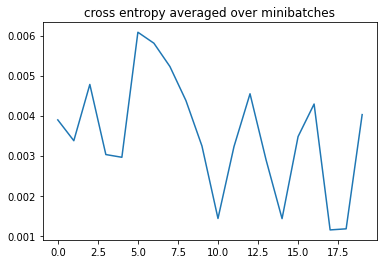

In [20]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses_GAT)
plt.show()